In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
from jax import device_put, devices
import jax.experimental.sparse as jsparse
from scipy import sparse

from innov.automaton import *
from innov.tree_gen import *
from innov.network_model_1 import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plt.rc('font', size=20)
np.set_printoptions(precision=4, linewidth=200)

# Define graph

In [170]:
el = 5, 50 # size of binary trees
samples = 1000
gamma = 0
dt = .1
key = random.PRNGKey(0)
k = 2
# define graph structure
tree = BiTree(*el, k, gamma)
# transform Ady into a sparse matrix
Ady = jsparse.BCOO.from_scipy_sparse(sparse.coo_array(tree.adj))
Ady.data = Ady.data.astype(jnp.int8)

def init_variables(N, samples):
    """Define an initial condition.
    
    Parameters
    ----------
    N : int
        Size of graph.
    samples : int
        Number of parallel jobs to run.
    """
    inn = jnp.zeros((samples, N), dtype=jnp.bool_)
    obs = jnp.zeros((samples, N), dtype=jnp.bool_)
    sub = jnp.zeros((samples, N), dtype=jnp.bool_)
    n = jnp.zeros((samples, N), dtype=jnp.int32)
    
    inn = inn.at[:,el[0]-1].set(True)
    obs = obs.at[:,0].set(True)
    sub = sub.at[:,1:el[0]].set(True)
    n = n.at[:,1:el[0]].set(10)
    return inn, obs, sub, n

samples = 10
dt = .01
key = random.PRNGKey(0)

tree = Tree(2, 500_000)
Ady = jsparse.BCOO.from_scipy_sparse(tree.adj)
Ady.data = Ady.data.astype(jnp.int8)

def init_variables(N, samples):
    """Define an initial condition.
    
    Parameters
    ----------
    N : int
        Size of graph.
    samples : int
        Number of parallel jobs to run.
    """
    inn = jnp.zeros((samples, N), dtype=jnp.bool_)
    obs = jnp.zeros((samples, N), dtype=jnp.bool_)
    sub = jnp.zeros((samples, N), dtype=jnp.bool_)
    n = jnp.zeros((samples, N), dtype=jnp.int32)
    
    inn = inn.at[:,12].set(True)
    obs = obs.at[:,0].set(True)
    sub = sub.at[:,1:13].set(True)
    n = n.at[:,1:13].set(10)
    return inn, obs, sub, n

# Setup sim

In [22]:
# setup simulation

r = 0.33
rd = 0.4
I = 0.8
G_in = 100
ro = 0.3
tmax = 800
print_t = 30
init_vars, one_loop, run_save = setup_auto_sim(N = Ady.shape[0],
                                               r = r,
                                               rd = rd,
                                               I = I,
                                               G_in = G_in,
                                               dt = dt,
                                               ro = ro,
                                               key = random.PRNGKey(0),
                                               samples = samples,
                                               Ady = Ady,
                                               init_fcn=init_variables)

# Run sim

In [172]:
start = time.time()
out_vars = run_save([key]+list(init_vars), int(print_t/dt), int(tmax/dt))
key, t, n, inn_front, obs_sub, in_sub_pop = out_vars
end = time.time()
end-start

267.6580924987793

In [180]:
start = time.time()
sim = RKPropagator1D( Ady.shape[0], sub_ix=[1, 2, 3, 4], inn = [4], obs = [0], Ady = tree.adj, n0=10, τo = ro, rd = rd, r = r, I = I, G_in= G_in, tmax = tmax, Δt = dt, λ = 1., method='frequency')
n_int, L, t, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()
end = time.time()
end-start

122.19489455223083

In [174]:
n_ = jnp.vstack(([decompress_density(*n_, ix0=0, ix1=el[1]*k+5-1) for n_ in n[-1]]))

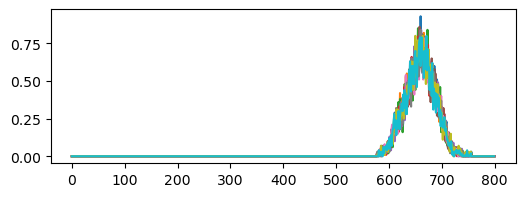

In [80]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,2))

y = n_.mean(0)
#y1= n_a_1.mean(0)
y_up = y + n_.std(0)
y_be = y - n_.std(0)
#ax.plot(y)
#ax.plot(n_int[-1])
for i in range(k):
    ax.plot(y[i::k], color = f'C{i}')
    #ax.plot(n_int[-1][i::2], ls = '--',color = f'C{i}')
#ax.plot(n_1[-1][::2], 'ob')
#ax.plot(n_1[-1][1::2], 'or')
#ax.plot(y1[::2], '--b')
#ax.plot(y1[1::2], '--r')
#ax.fill_between(range(y[::2].size), y_be[::2], y_up[::2], alpha=.2)
#ax.fill_between(range(y[1::2].size), y_be[1::2], y_up[1::2], alpha=.2)

#ax.set(xlim=(0,10))

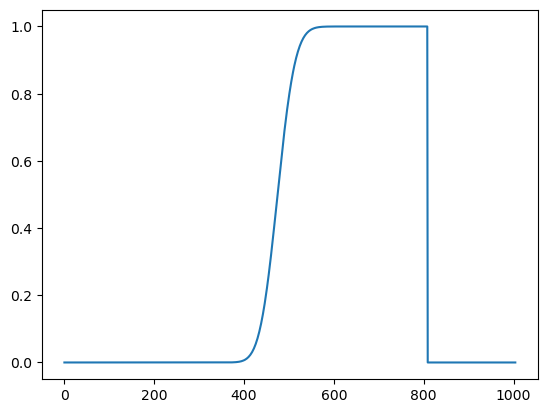

In [181]:
plt.plot(sim.P_cum)

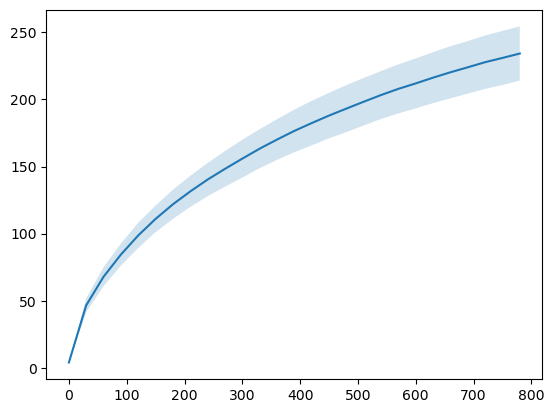

In [177]:
L_t= []
L_std = []
#L_be = []
for i in range(len(in_sub_pop)):
    L_t.append(np.average(np.sum(in_sub_pop[i], axis=1)))
    L_std.append(np.std(np.sum(in_sub_pop[i], axis=1)))
plt.plot(np.arange(0, 800, 30), L_t)
plt.fill_between(np.arange(0, 800, 30), np.array(L_t)-np.array(L_std),  np.array(L_t)+np.array(L_std), alpha=.2)
#plt.plot(t, L)

0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
0.0 7
0.0 8
0.0 9
0.0 10
0.0 11


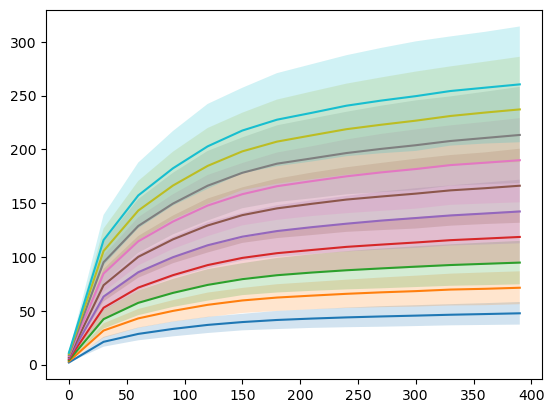

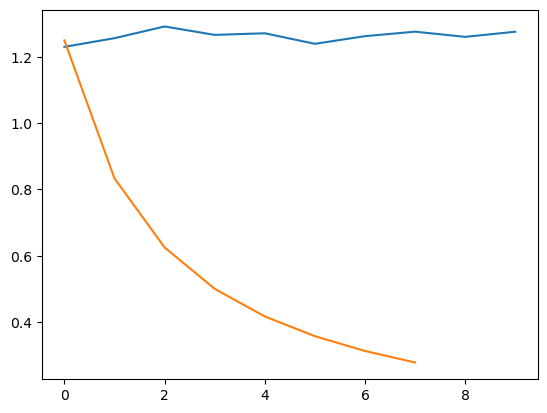

1.0 2
1.0 3
1.0 4
1.0 5
1.0 6
1.0 7
1.0 8
1.0 9
1.0 10
1.0 11


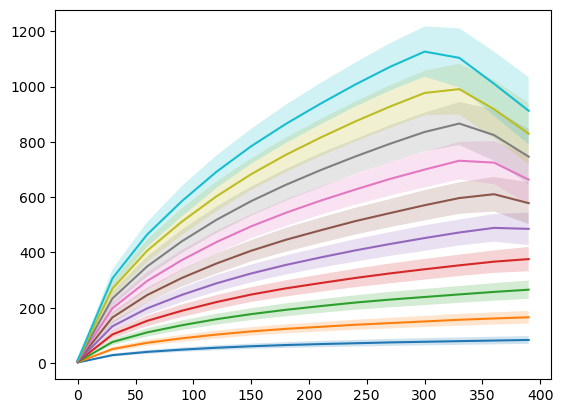

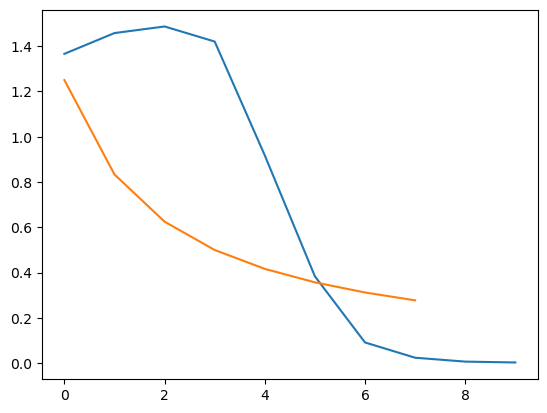

In [134]:
for γ in np.arange(0.0, 1.1, 1.):
    no = []
    for k1 in range(2, 12, 1):
        print(γ, k1)
        el = 1, 200 # size of binary trees
        samples = 1000
        gamma = γ
        dt = .1
        key = random.PRNGKey(0)
        k = k1
        # define graph structure
        tree = BiTree(*el, k, gamma)
        # transform Ady into a sparse matrix
        Ady = jsparse.BCOO.from_scipy_sparse(sparse.coo_array(tree.adj))
        Ady.data = Ady.data.astype(jnp.int8)

        def init_variables(N, samples):
            """Define an initial condition.

            Parameters
            ----------
            N : int
                Size of graph.
            samples : int
                Number of parallel jobs to run.
            """
            inn = jnp.zeros((samples, N), dtype=jnp.bool_)
            obs = jnp.zeros((samples, N), dtype=jnp.bool_)
            sub = jnp.zeros((samples, N), dtype=jnp.bool_)
            n = jnp.zeros((samples, N), dtype=jnp.int32)

            innn = [el[0]+i for i in range(k)]
            inn = inn.at[:,innn, ].set(True)
            obs = obs.at[:,0].set(True)
            sub = sub.at[:,innn].set(True)
            n = n.at[:,innn].set(100)
            return inn, obs, sub, n


        # setup simulation
        init_vars, one_loop, run_save = setup_auto_sim(N = Ady.shape[0],
                                                       r = .3,
                                                       rd = .4,
                                                       I = 0.8,
                                                       G_in = 10*k1,
                                                       dt = dt,
                                                       ro = .3,
                                                       key = random.PRNGKey(0),
                                                       samples = samples,
                                                       Ady = Ady,
                                                       init_fcn=init_variables)

        start = time.time()
        out_vars = run_save([key]+list(init_vars), int(300), 4000)
        key, t, n, inn_front, obs_sub, in_sub_pop = out_vars
        end = time.time()

        no1=0
        for i in range(1000):
            for j in np.where(inn_front[-1][i])[0]:
                #print(i, j)
                if j in n[-1][i][1]:
                    no1+=n[-1][i][0][n[-1][i][1] == j]/(k1*1000)
        no.append(no1)
        
        L_t= []
        L_std = []
        #L_be = []
        for i in range(len(in_sub_pop)):
            L_t.append(np.average(np.sum(in_sub_pop[i], axis=1)))
            L_std.append(np.std(np.sum(in_sub_pop[i], axis=1)))
        plt.plot(np.arange(0, 400, 30), L_t)
        plt.fill_between(np.arange(0, 400, 30), np.array(L_t)-np.array(L_std),  np.array(L_t)+np.array(L_std), alpha=.2)
    plt.show()
    nfroms = []
    for i in range(2, 10, 1):
        nfroms.append(no_steady(0.3, 0.4, i, 0.3))

    plt.plot(no)
    plt.plot(nfroms)
    plt.show()

In [5]:
L_aut = {}
L_int = {}
n_aut = {}
n_int = {}
n0_aut = {}
#n0_int = {}
r = 0.2
rd = 0.4
ro = 0.4
I = 0.5
G = 10

for k1 in [2]:
    L_aut[k1] = {}
    L_int[k1] = {}
    n_aut[k1] = {}
    n_int[k1] = {}
    n0_aut[k1] = {}
    for γ in np.arange(0.0, 1.1, 0.1):
        print(γ, k1)
        el = 5, 800 # size of binary trees
        samples = 100
        gamma = γ
        dt = .1
        key = random.PRNGKey(0)
        k = k1
        # define graph structure
        tree = BiTree(*el, k, gamma)
        # transform Ady into a sparse matrix
        Ady = jsparse.BCOO.from_scipy_sparse(sparse.coo_array(tree.adj))
        Ady.data = Ady.data.astype(jnp.int8)

        def init_variables(N, samples):
            """Define an initial condition.

            Parameters
            ----------
            N : int
                Size of graph.
            samples : int
                Number of parallel jobs to run.
            """
            inn = jnp.zeros((samples, N), dtype=jnp.bool_)
            obs = jnp.zeros((samples, N), dtype=jnp.bool_)
            sub = jnp.zeros((samples, N), dtype=jnp.bool_)
            n = jnp.zeros((samples, N), dtype=jnp.int32)

            innn = [el[0]+i for i in range(k)]
            inn = inn.at[:,innn, ].set(True)
            obs = obs.at[:,0].set(True)
            sub = sub.at[:,innn].set(True)
            n = n.at[:,innn].set(100)
            return inn, obs, sub, n


        # setup simulation
        init_vars, one_loop, run_save = setup_auto_sim(N = Ady.shape[0],
                                                       r = r,
                                                       rd = rd,
                                                       I = I,
                                                       G_in = G*k1,
                                                       dt = dt,
                                                       ro = ro,
                                                       key = random.PRNGKey(0),
                                                       samples = samples,
                                                       Ady = Ady,
                                                       init_fcn=init_variables)

        start = time.time()
        out_vars = run_save([key]+list(init_vars), int(1000), 16000)
        key, t, n, inn_front, obs_sub, in_sub_pop = out_vars
        end = time.time()
        innn = [el[0]+i for i in range(k)]
        print(end - start)
        start = time.time()
        
        #sim = RKPropagator1D( Ady.shape[0], sub_ix=innn, inn = innn, obs = [0], Ady = tree.adj, n0=100, τo = ro, rd = rd, r = r, I = I, G_in= G, tmax = 3200, Δt = 0.1, λ = 1., method='frequency')
        #n_int, L, t, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()
        #end = time.time()
        #print(end - start)
        
        no1=0
        for i in range(100):
            for j in np.where(inn_front[-1][i])[0]:
                #print(i, j)
                if j in n[-1][i][1]:
                    no1+=n[-1][i][0][n[-1][i][1] == j]/(k1*100)
        n0_aut[k1][γ]= no1
        n_ = jnp.vstack(([decompress_density(*n_, ix0=0, ix1=el[1]*k+5-1) for n_ in n[-1]]))
        
        L_t= []
        L_std = []
        #L_be = []
        for i in range(len(in_sub_pop)):
            L_t.append(np.average(np.sum(in_sub_pop[i], axis=1)))
            L_std.append(np.std(np.sum(in_sub_pop[i], axis=1)))
        L_aut[k1][γ] = [L_t, L_std]
        #L_int[k1][γ] = L
        n_aut[k1][γ] = n
        #n_int[k1][γ] = n_int
    plt.show()

0.0 2
100.58535814285278
0.1 2
75.92881417274475
0.2 2
75.84718036651611
0.30000000000000004 2
74.2535948753357
0.4 2
74.44002223014832
0.5 2
77.05635356903076
0.6000000000000001 2
74.33270168304443
0.7000000000000001 2
72.8747923374176
0.8 2
76.51377940177917
0.9 2
74.87835478782654
1.0 2
71.3189651966095


In [56]:
len(in_sub_pop)

21

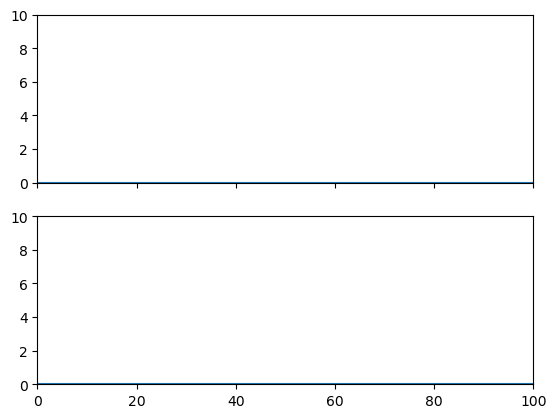

In [427]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax = ax.ravel()

y = n_[:,::2].mean(0)
y_up = y + n_[:,::2].std(0)
y_be = y - n_[:,::2].std(0)
ax[0].plot(y)
ax[0].fill_between(range(y.size), y_be, y_up, alpha=.1)

y = n_[:,1::2].mean(0)
y_up = y + n_[:,1::2].std(0)
y_be = y - n_[:,1::2].std(0)
ax[1].plot(y)
ax[1].fill_between(range(y.size), y_be, y_up, alpha=.1)

for a in ax:
    a.set(ylim=(0,10), xlim=(0, 100))

[Text(0.5, 0, 'length'), Text(0, 0.5, 'frequency')]

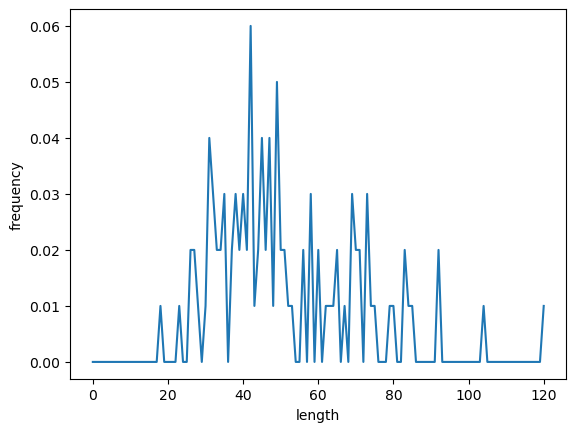

In [428]:
freq = np.bincount(in_sub_pop[-1].sum(1))
freq = freq / freq.sum()

fig, ax = plt.subplots()
ax.plot(freq)
ax.set(xlabel='length', ylabel='frequency')

In [45]:
# condition on L
Lmin = 55
Lmax = 60

ix = (in_sub_pop[-1].sum(1)>=Lmin) & (in_sub_pop[-1].sum(1)<=Lmax)
n_ = jnp.vstack(([decompress_density(*n_, ix1=200) for n_ in n[-1]]))[ix]

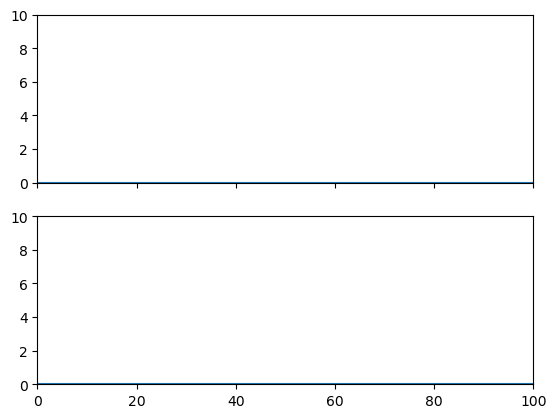

In [70]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax = ax.ravel()

y = n_[:,::2].mean(0)
y_up = y + n_[:,::2].std(0)
y_be = y - n_[:,::2].std(0)
ax[0].plot(y)
ax[0].fill_between(range(y.size), y_be, y_up, alpha=.1)

y = n_[:,1::2].mean(0)
y_up = y + n_[:,1::2].std(0)
y_be = y - n_[:,1::2].std(0)
ax[1].plot(y)
ax[1].fill_between(range(y.size), y_be, y_up, alpha=.1)

for a in ax:
    a.set(ylim=(0,10), xlim=(0, 100))

In [38]:
np.average(np.sum(obs_sub[-1], axis=1))
Obs_in_time[-1][0]

155

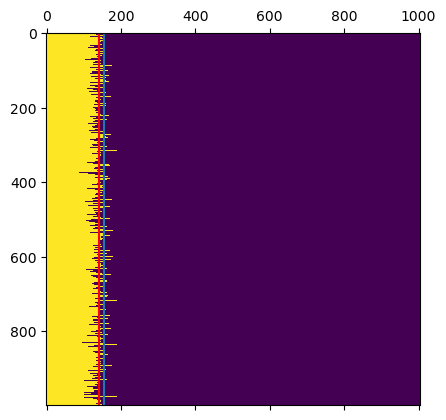

In [35]:
plt.matshow(obs_sub[-1])
plt.vlines(Obs_in_time[-1][0], 0, 999)
#plt.vlines(Obs_in_time[-1][1], 0, 999)
plt.vlines(np.average(np.sum(obs_sub[-1], axis=1)), 0, 999, color = 'r')

0.4 0
0.4 1
0.4 2
0.4 3
0.4 4
0.4 5
0.4 6
0.4 7
0.4 8
0.4 9
0.4 10
0.4 11
0.4 12
0.4 13
0.4 14


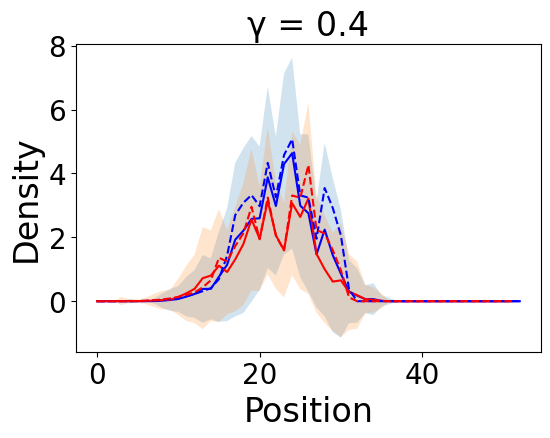

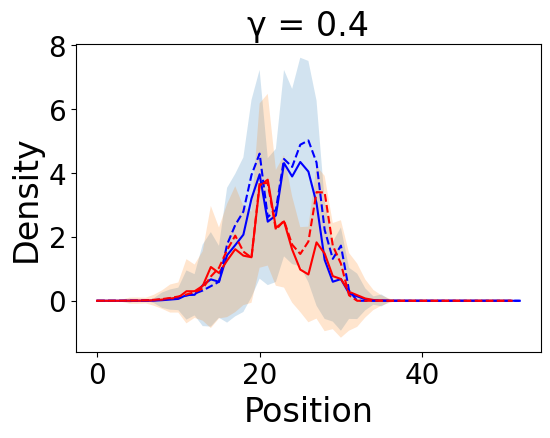

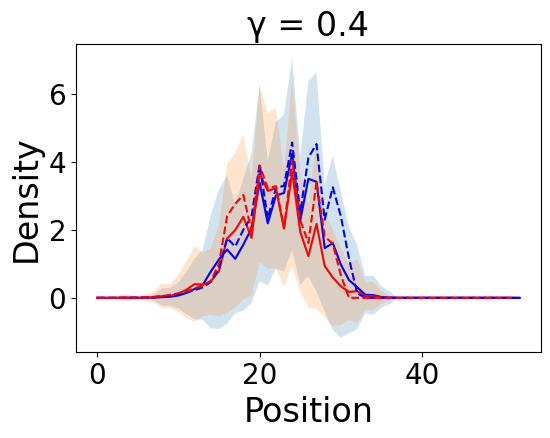

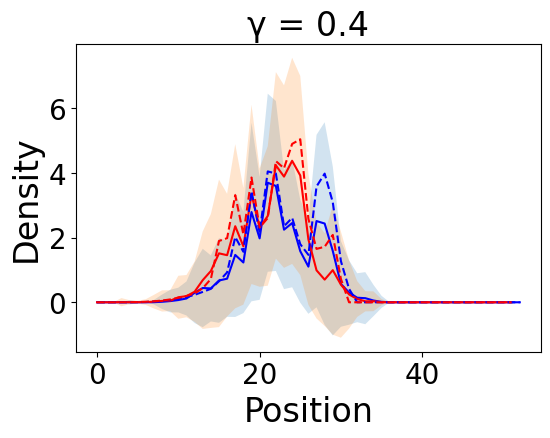

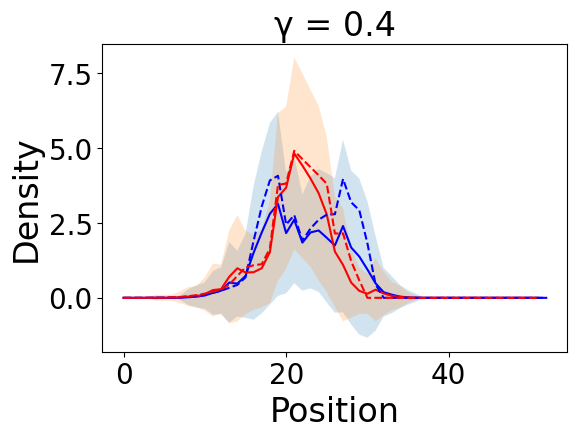

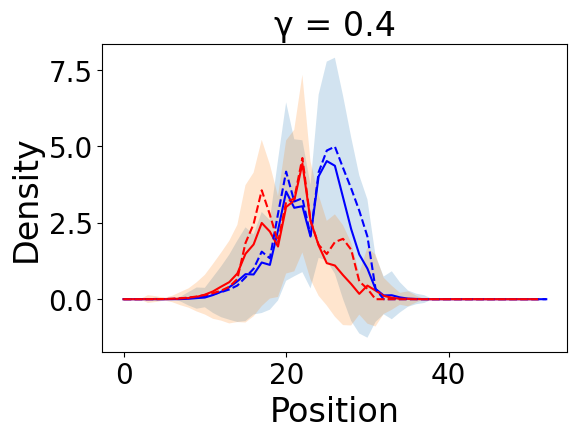

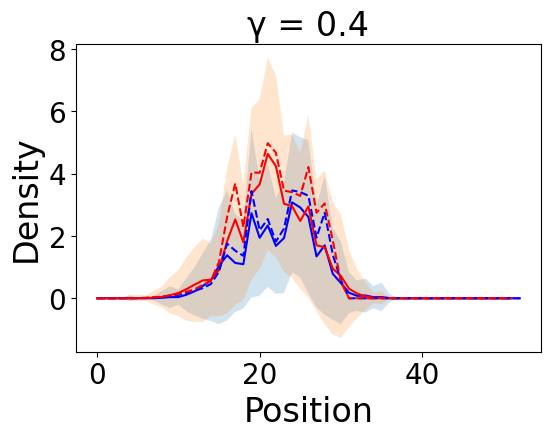

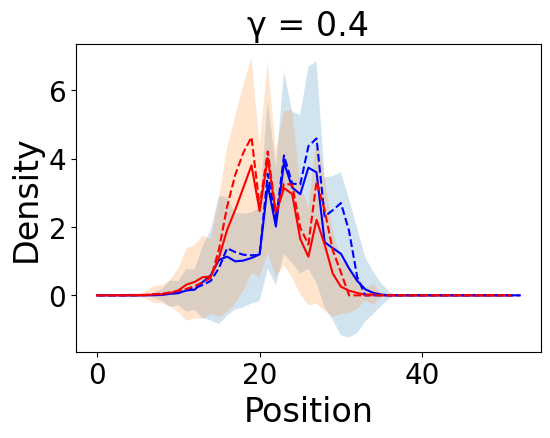

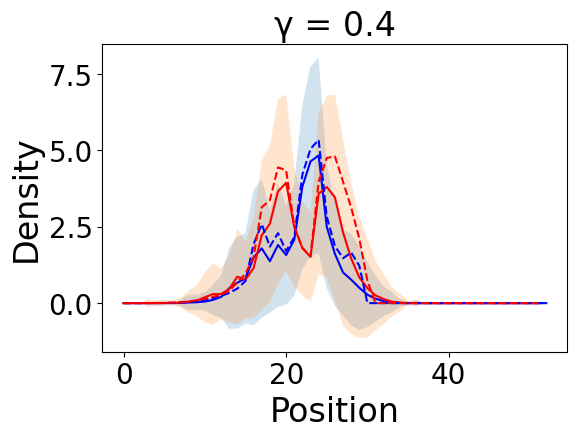

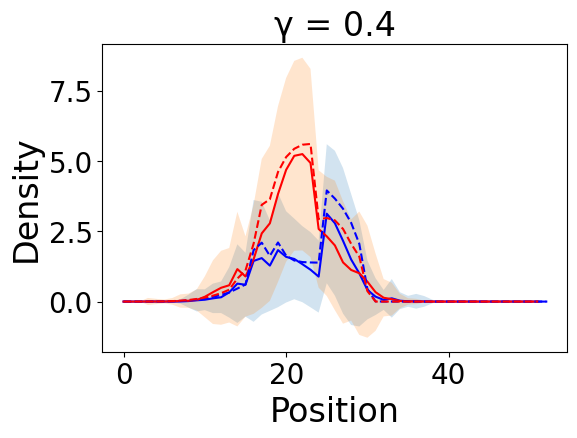

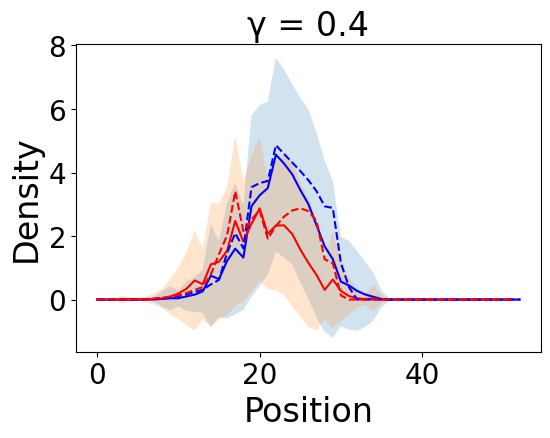

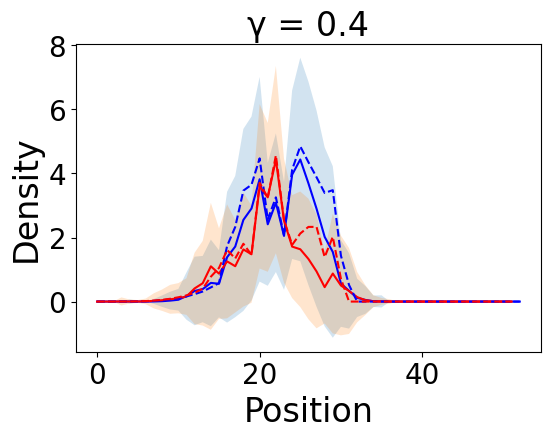

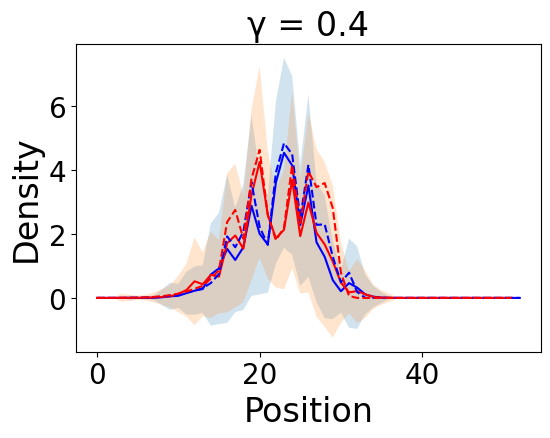

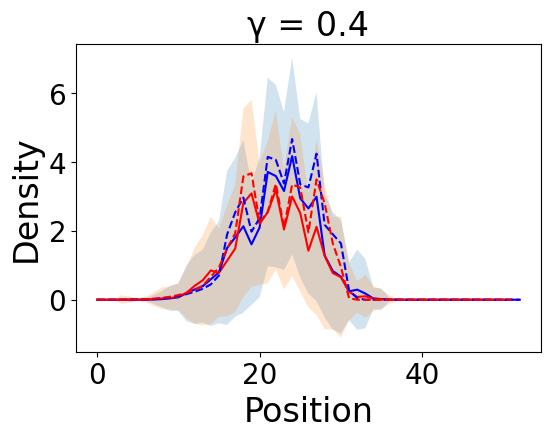

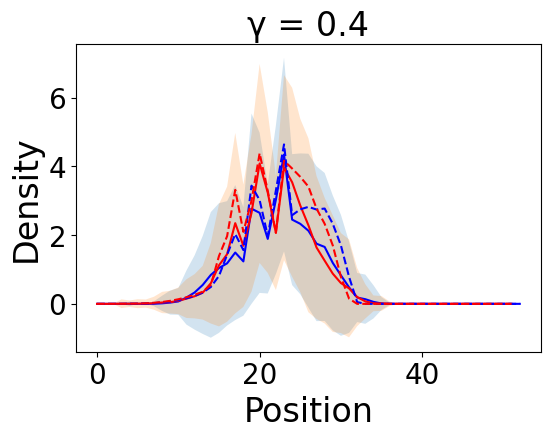

In [171]:
L_aut = {}
L_int = {}

stde_aut = {}
stde_inn_aut = {}

n_int_γ = {}
n_aut_γ = {}
dist_MF_aut = {}
samples = 1000
#ensemble_
for γ in np.arange(0.4, 0.6, .2):
    n_int_γ_ = []
    n_aut_γ_ = []
    dist_MF_aut_ = []
    L_aut_ = []
    L_int_ = []
    k=2
    for rep in range(15):
        print(γ, rep)
        gamma = γ
        dt = .1
        el = 5, 50
        key = random.PRNGKey(0)

        # define graph structure
        tree = BiTree(*el, 2, gamma)
        # transform Ady into a sparse matrix
        Ady = jsparse.BCOO.from_scipy_sparse(sparse.coo_array(tree.adj))
        Ady.data = Ady.data.astype(jnp.int8)

        def init_variables(N, samples):
            """Define an initial condition.

            Parameters
            ----------
            N : int
                Size of graph.
            samples : int
                Number of parallel jobs to run.
            """
            inn = jnp.zeros((samples, N), dtype=jnp.bool_)
            obs = jnp.zeros((samples, N), dtype=jnp.bool_)
            sub = jnp.zeros((samples, N), dtype=jnp.bool_)
            n = jnp.zeros((samples, N), dtype=jnp.int32)

            inn = inn.at[:,el[0]-1].set(True)
            obs = obs.at[:,0].set(True)
            sub = sub.at[:,1:el[0]].set(True)
            n = n.at[:,1:el[0]].set(10)
            return inn, obs, sub, n

        init_vars, one_loop, run_save = setup_auto_sim(N = Ady.shape[0],
                                                   r = .3,
                                                   rd = .4,
                                                   I = 0.8,
                                                   G_in = 10,
                                                   dt = dt,
                                                   ro = .3,
                                                   key = random.PRNGKey(0),
                                                   samples = samples,
                                                   Ady = Ady,
                                                   init_fcn=init_variables)
        start = time.time()
        out_vars = run_save([key]+list(init_vars), int(60), 600)
        key, t, n, inn_front, obs_sub, in_sub_pop = out_vars
        end = time.time()
        end-start

        n_ = jnp.vstack(([decompress_density(*n_, ix0=0, ix1= k*el[1]+el[0]-1) for n_ in n[-1]]))
        n_aut_γ_.append(n_)
        sim = RKPropagator1D( Ady.shape[0], sub_ix=[1, 2, 3, 4], inn = [4], obs = [0], Ady = tree.adj, n0=10, τo = 0.3, rd = 0.4, r = 0.3, I = 0.8, G_in= 10, tmax = 60, Δt = 0.1, λ = 1., method='frequency')
        n_int, L, t, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()

        n_int_γ_.append(n_int)
        fig, ax = plt.subplots(figsize=(6,4), ncols=1, nrows=1)

        y = n_.mean(0)
        #y1= n_a_1.mean(0)
        y_up = y + n_.std(0)
        y_be = y - n_.std(0)
        ax.plot(y[::2], '-b')
        ax.plot(y[1::2], '-r')
        ax.plot(n_int[-1][::2], '--b')
        ax.plot(n_int[-1][1::2], '--r')
        ax.set_ylabel('Density', fontsize='large')
        ax.set_xlabel('Position', fontsize='large')
        ax.set_title("γ = "+str(format(γ, '.1f')))
        ax.fill_between(range(y[::2].size), y_be[::2], y_up[::2], alpha=.2)
        ax.fill_between(range(y[1::2].size), y_be[1::2], y_up[1::2], alpha=.2)

        dist_MF_aut_.append(np.sqrt(np.sum((y - n_int[-1])*(y - n_int[-1]))))
        L_aut_.append(np.average(np.sum(in_sub_pop[-1], axis=1)))
        L_int_.append(L[-1])
    L_aut[γ] = L_aut_
    L_int[γ] = L_int_
    n_int_γ[γ] = n_int_γ_
    n_aut_γ[γ] = n_aut_γ_
    dist_MF_aut[γ] = dist_MF_aut_

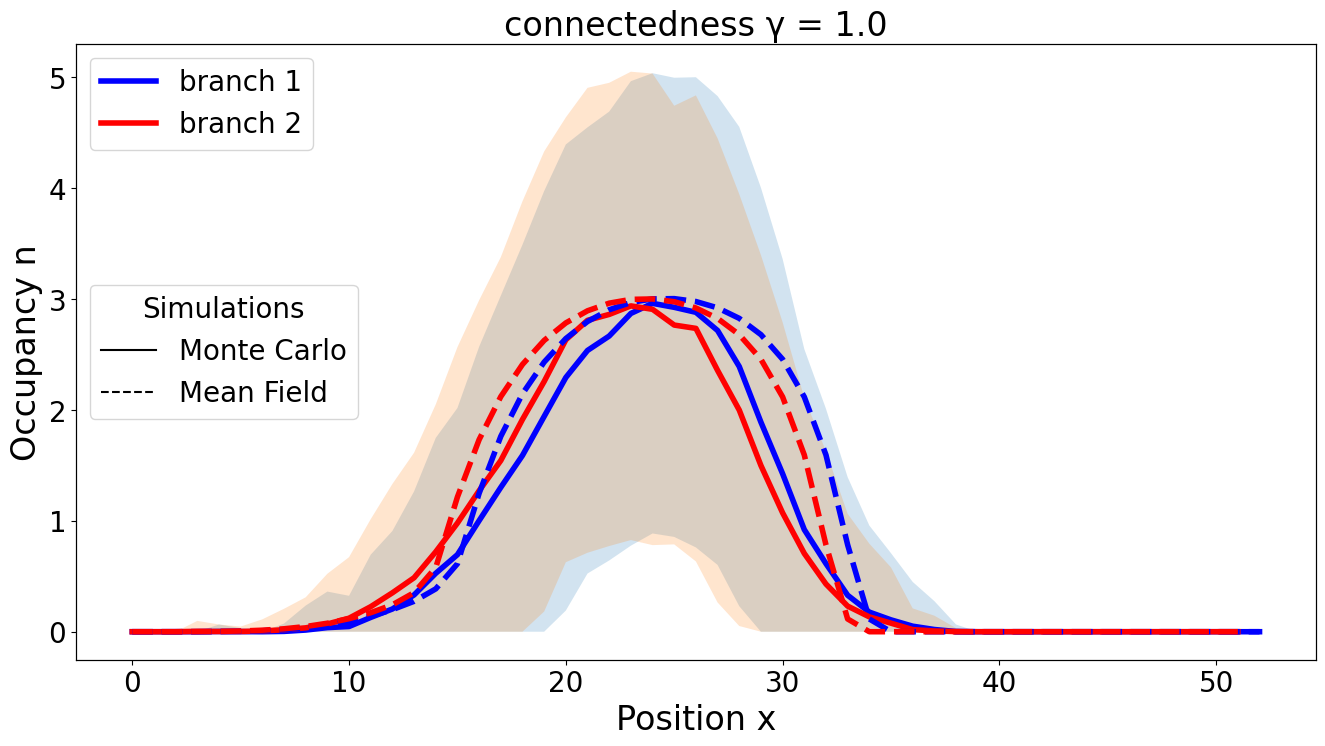

In [168]:
        plot_lines=[]
        fig, ax = plt.subplots(figsize=(16,8), ncols=1, nrows=1)
        ax.plot(y[::2], '-b', lw =4, label = "branch 1")
        ax.plot(y[1::2], '-r', lw =4, label = "branch 2")
        ax.plot(n_int[-1][::2], '--b', lw = 4)
        ax.plot(n_int[-1][1::2], '--r', lw = 4)
        ax.set_ylabel('Occupancy n', fontsize='large')
        ax.set_xlabel('Position x', fontsize='large')
        ax.set_title("connectedness γ = "+str(format(γ, '.1f')))
        ax.fill_between(range(y[::2].size), y_be[::2], y_up[::2], alpha=.2)
        ax.fill_between(range(y[1::2].size), y_be[1::2], y_up[1::2], alpha=.2)
        ax2 = ax.twinx()
        #ax2 = ax.twiny()
        ax2.plot(np.NaN, np.NaN, '-k', label = 'Monte Carlo')
        ax2.plot(np.NaN, np.NaN, '--k', label = 'Mean Field')
        ax2.get_yaxis().set_visible(False)
        #plot_lines.append([l1, l2])
        #leg1 = plt.legend(plot_lines, ["Monte Carlo", "Mean field"], loc='center left', title = 'Simulations')
        ax.legend(loc='upper left')
        ax2.legend(loc='center left', title = 'Simulations')
        

In [126]:
len(n_[0])

55

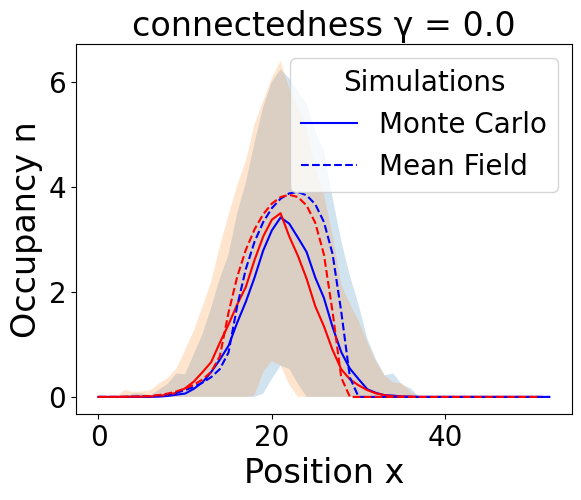

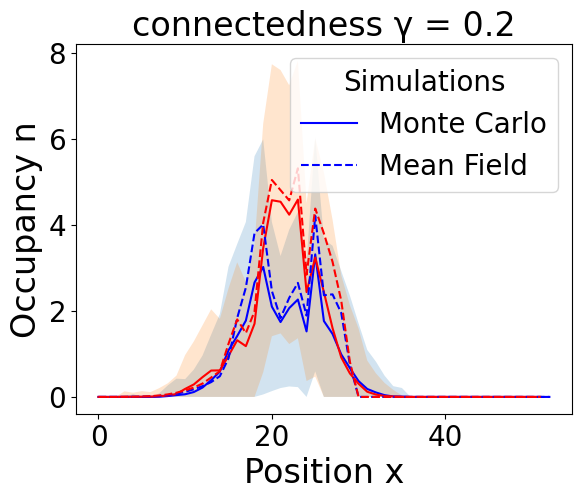

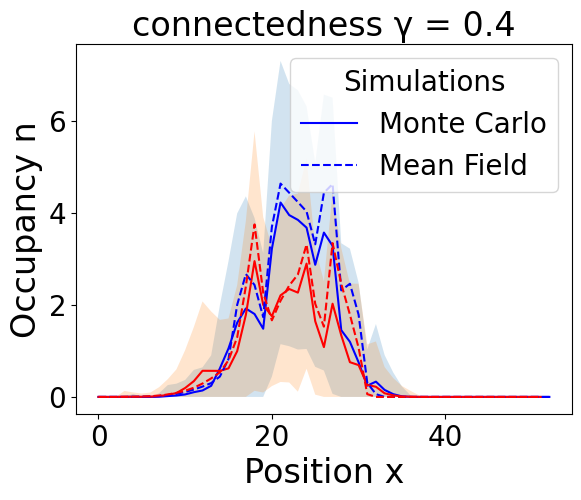

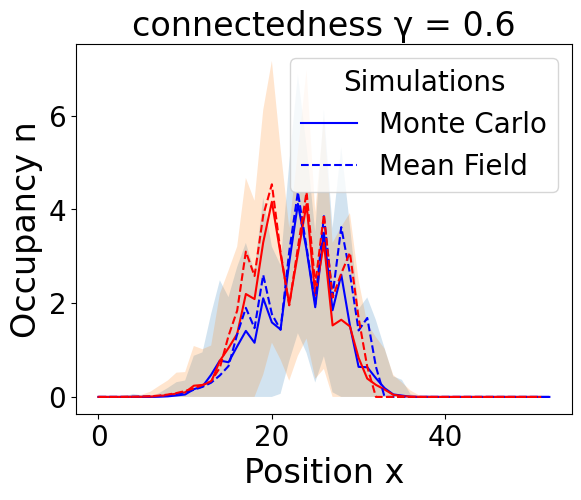

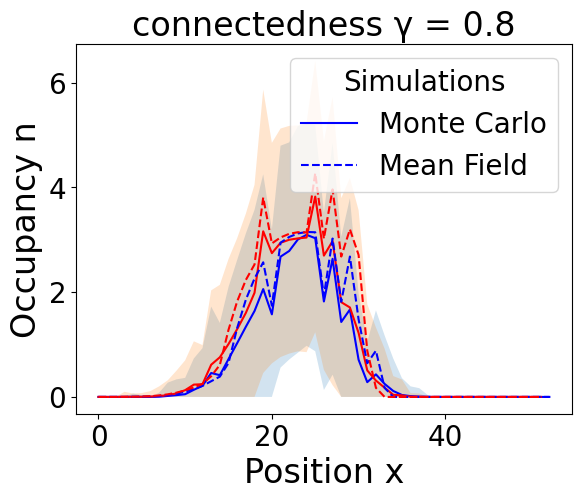

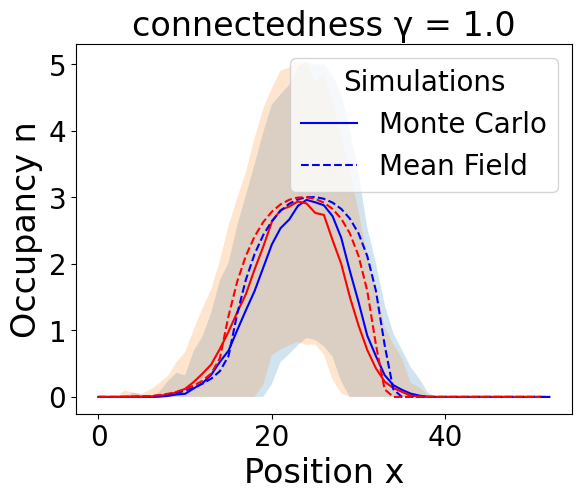

In [129]:
a = 0
n_std_γ = []
for γ in np.arange(0.0, 1.1, .2):
    n_= n_aut_γ[γ][0]
    n_int = n_int_γ[γ][0]
    fig, ax = plt.subplots()
    y = n_.mean(0)
    #y1= n_a_1.mean(0)
    y_up = y + n_.std(0)
    y_be = y - n_.std(0)
    n_std_γ.append(n_.std(0))
    y_be = y_be.at[y_be<0].set(0)
    ax.plot(y[::2], '-b', label="Monte Carlo")
    ax.plot(y[1::2], '-r')
    ax.plot(n_int[-1][::2], '--b', label = "Mean Field")
    ax.plot(n_int[-1][1::2], '--r')
    ax.set_ylabel('Occupancy n', fontsize='large')
    ax.set_xlabel('Position x', fontsize='large')
    ax.set_title("connectedness γ = "+str(format(γ, '.1f')))
    ax.fill_between(range(y[::2].size), y_be[::2], y_up[::2], alpha=.2)
    ax.fill_between(range(y[1::2].size), y_be[1::2], y_up[1::2], alpha=.2)
    ax.plot([], '-k', label = "Monte Carlo")
    ax.plot([], '-k', label = "Mena Field")
    ax.legend(loc= 'best', title = 'Simulations')
    a+=1

IndexError: list index out of range

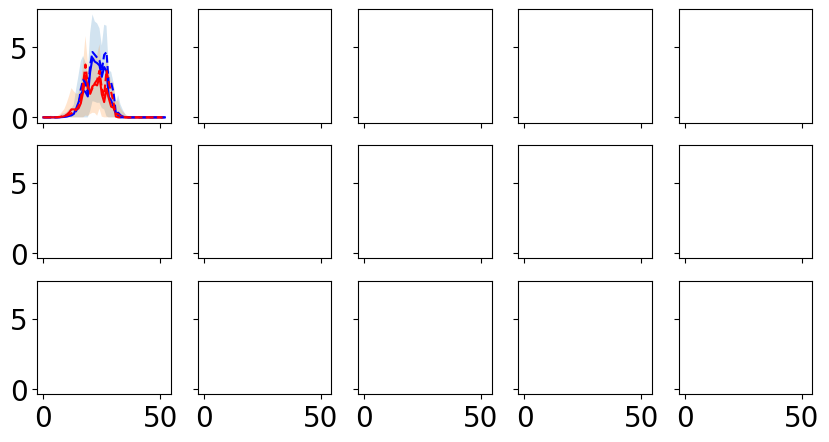

In [170]:
fig, ax = plt.subplots(figsize = (10, 5), ncols = 5, nrows = 3, sharex = True, sharey = True)
a = 0
b = 0
n_std_γ = []
for i in range(3):
    for j in range(5):
        n_= n_aut_γ[0.4][i*5+j]
        n_int = n_int_γ[0.4][i*5+j]
        y = n_.mean(0)
        #y1= n_a_1.mean(0)
        y_up = y + n_.std(0)
        y_be = y - n_.std(0)
        n_std_γ.append(n_.std(0))
        y_be = y_be.at[y_be<0].set(0)
        ax[i][j].plot(y[::2], '-b')
        ax[i][j].plot(y[1::2], '-r')
        ax[i][j].plot(n_int[-1][::2], '--b')
        ax[i][j].plot(n_int[-1][1::2], '--r')
        ax[i][j].fill_between(range(y[::2].size), y_be[::2], y_up[::2], alpha=.2)
        ax[i][j].fill_between(range(y[1::2].size), y_be[1::2], y_up[1::2], alpha=.2)

ax[1][0].set_ylabel('Occupancy n', fontsize='large')
ax[2][2].set_xlabel('Position x', fontsize='large')
ax[0][2].set_title("connectedness γ = "+str(format(γ, '.1f')))


Text(0.5, 0, 'Position x')

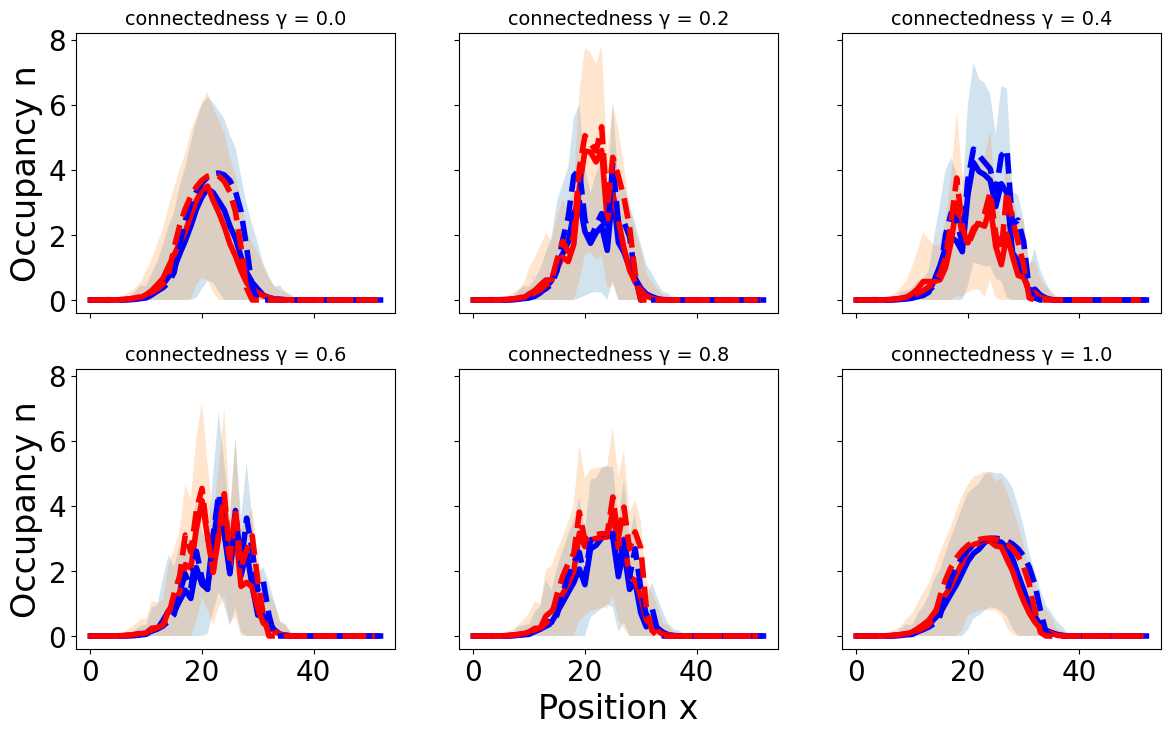

In [140]:
fig, ax = plt.subplots(figsize = (14, 8), ncols = 3, nrows = 2, sharex = True, sharey = True)
a = 0
b = 0
n_std_γ = []
for γ in np.arange(0.0, 1.1, 0.2):
        n_= n_aut_γ[γ][0]
        n_int = n_int_γ[γ][0]
        y = n_.mean(0)
        #y1= n_a_1.mean(0)
        y_up = y + n_.std(0)
        y_be = y - n_.std(0)
        n_std_γ.append(n_.std(0))
        y_be = y_be.at[y_be<0].set(0)
        ax[a][b].plot(y[::2], '-b', lw =4)
        ax[a][b].plot(y[1::2], '-r', lw =4)
        ax[a][b].plot(n_int[-1][::2], '--b', lw =4)
        ax[a][b].plot(n_int[-1][1::2], '--r', lw =4)
        ax[a][b].fill_between(range(y[::2].size), y_be[::2], y_up[::2], alpha=.2)
        ax[a][b].fill_between(range(y[1::2].size), y_be[1::2], y_up[1::2], alpha=.2)
        ax[a][b].set_title("connectedness γ = "+str(format(γ, '.1f')), fontsize = 'x-small')
        b+=1
        if b%3==0:
            b=0
            a+=1
ax[1][0].set_ylabel('Occupancy n', fontsize='large')
ax[0][0].set_ylabel('Occupancy n', fontsize='large')
ax[1][1].set_xlabel('Position x', fontsize='large')


In [113]:
n_int_γ

{}

0.0 0
0.0 1


KeyboardInterrupt: 

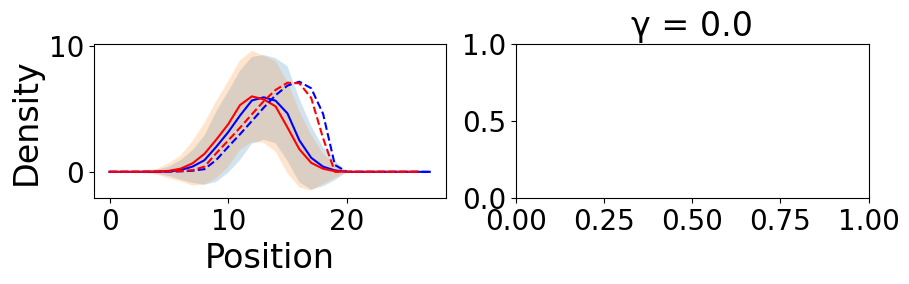

In [114]:
L_aut = {}
L_int = {}

stde_aut = {}
stde_inn_aut = {}

n_int_k = {}
n_aut_k = {}
dist_MF_aut = {}
samples = 1000
#ensemble_
for k in np.arange(1, 16, 1):
    n_int_γ_ = []
    n_aut_γ_ = []
    dist_MF_aut_ = []
    L_aut_ = []
    L_int_ = []
    for rep in range(15):
        print(γ, rep)
        gamma = 0.5
        dt = .1
        el = 5, 50
        key = random.PRNGKey(0)

        # define graph structure
        tree = BiTree(*el, k, gamma)
        # transform Ady into a sparse matrix
        Ady = jsparse.BCOO.from_scipy_sparse(sparse.coo_array(tree.adj))
        Ady.data = Ady.data.astype(jnp.int8)

        def init_variables(N, samples):
            """Define an initial condition.

            Parameters
            ----------
            N : int
                Size of graph.
            samples : int
                Number of parallel jobs to run.
            """
            inn = jnp.zeros((samples, N), dtype=jnp.bool_)
            obs = jnp.zeros((samples, N), dtype=jnp.bool_)
            sub = jnp.zeros((samples, N), dtype=jnp.bool_)
            n = jnp.zeros((samples, N), dtype=jnp.int32)

            inn = inn.at[:,el[0]-1].set(True)
            obs = obs.at[:,0].set(True)
            sub = sub.at[:,1:el[0]].set(True)
            n = n.at[:,1:el[0]].set(10)
            return inn, obs, sub, n

        init_vars, one_loop, run_save = setup_auto_sim(N = Ady.shape[0],
                                                   r = .3,
                                                   rd = .4,
                                                   I = 0.8,
                                                   G_in = 10,
                                                   dt = dt,
                                                   ro = .3,
                                                   key = random.PRNGKey(0),
                                                   samples = samples,
                                                   Ady = Ady,
                                                   init_fcn=init_variables)
        start = time.time()
        out_vars = run_save([key]+list(init_vars), int(60), 600)
        key, t, n, inn_front, obs_sub, in_sub_pop = out_vars
        end = time.time()
        end-start

        n_ = jnp.vstack(([decompress_density(*n_, ix0=0, ix1= k*el[1]+el[0]-1) for n_ in n[-1]]))
        n_aut_γ_.append(n_)
        sim = RKPropagator1D( Ady.shape[0], sub_ix=[1, 2, 3, 4], inn = [4], obs = [0], Ady = tree.adj, n0=10, τo = 0.3, rd = 0.4, r = 0.3, I = 0.8, G_in= 10, tmax = 60, Δt = 0.1, λ = 1., method='frequency')
        n_int, L, t, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()

        n_int_γ_.append(n_int)
        fig, ax = plt.subplots(figsize=(10,2), ncols=2, nrows=1)

        y = n_.mean(0)
        #y1= n_a_1.mean(0)
        y_up = y + n_.std(0)
        y_be = y - n_.std(0)
        ax[0].plot(y[::2], '-b')
        ax[0].plot(y[1::2], '-r')
        ax[0].plot(n_int[-1][::2], '--b')
        ax[0].plot(n_int[-1][1::2], '--r')
        ax[0].set_ylabel('Density', fontsize='large')
        ax[0].set_xlabel('Position', fontsize='large')
        ax[1].set_title("γ = "+str(format(γ, '.1f')))
        ax[0].fill_between(range(y[::2].size), y_be[::2], y_up[::2], alpha=.2)
        ax[0].fill_between(range(y[1::2].size), y_be[1::2], y_up[1::2], alpha=.2)

        dist_MF_aut_.append(np.sqrt(np.sum((y - n_int[-1])*(y - n_int[-1]))))
        L_aut_.append(np.average(np.sum(in_sub_pop[-1], axis=1)))
        L_int_.append(L[-1])
    L_aut[k] = L_aut_
    L_int[k] = L_int_
    n_int_k[k] = n_int_γ_
    n_aut_k[k] = n_aut_γ_
    dist_MF_aut[γ] = dist_MF_aut_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


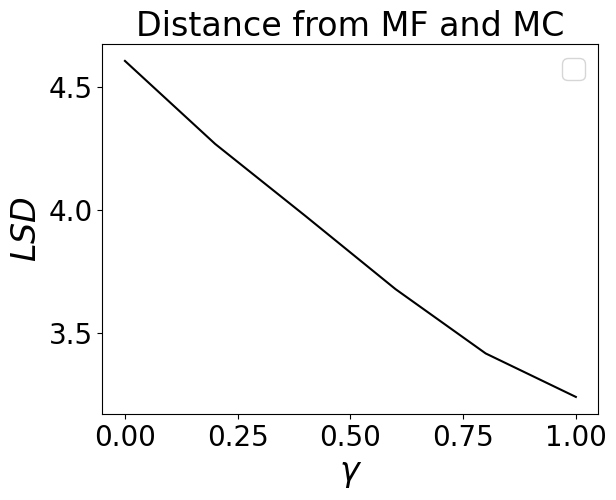

In [82]:
fig, ax = plt.subplots()
a = 1
b = 0
ax.set(title="Distance from MF and MC")
ax.plot(np.arange(0.0, 1.1, 0.2), dist_MF_aut[0:6], "k")
#ax.plot( 0.5, stde_inn[-1], 'ro', label = 'unbalanced')
ax.set_ylabel(r'$LSD$', fontsize='large')
# ax[0].set_xlabel(r'obsolescence rate $r_o/r$', fontsize='large')
ax.set_xlabel(r'$γ$', fontsize='large')
ax.legend(loc = 'best')

In [96]:
n_int_γ

{0.4: {...}}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


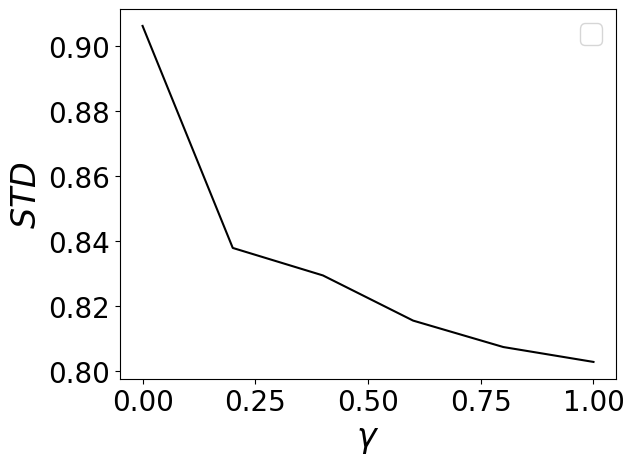

In [81]:
fig, ax = plt.subplots()
a = 1
b = 0
ax.set(title="")
ax.plot(np.arange(0.0, 1.1, 0.2), np.average(n_std_γ, axis=1), "k")
#ax.plot( 0.5, stde_inn[-1], 'ro', label = 'unbalanced')
ax.set_ylabel(r'$STD$', fontsize='large')
# ax[0].set_xlabel(r'obsolescence rate $r_o/r$', fontsize='large')
ax.set_xlabel(r'$γ$', fontsize='large')
ax.legend(loc = 'best')

In [20]:
from innov.simple_model import*

In [153]:
L_γ = []
for γ in np.arange(0.0, 1.01, 0.01):
    ode2_net = ODE2_network( G= 100/0.2, ro= 0.4/0.2, rd = 0.4/0.2, I = 0.5, gamma=γ, k = 10, L=None, alpha=1., Q=2)
    L_γ.append(ode2_net.L)

In [137]:
el = 5, 200 # size of binary trees
samples = 1000
gamma = 1
dt = .1
key = random.PRNGKey(0)
k = 2
# define graph structure
tree = BiTree(*el, k, gamma)
# transform Ady into a sparse matrix
Ady = jsparse.BCOO.from_scipy_sparse(sparse.coo_array(tree.adj))

In [146]:

sim = RKPropagator1D( Ady.shape[0], sub_ix=[1, 2, 3, 4], inn = [4], obs = [0], Ady = tree.adj, n0=10, τo = ro, rd = rd, r = r, I = I, G_in= G_in, k = k, tmax = tmax, Δt = dt, λ = 1., method='frequency')


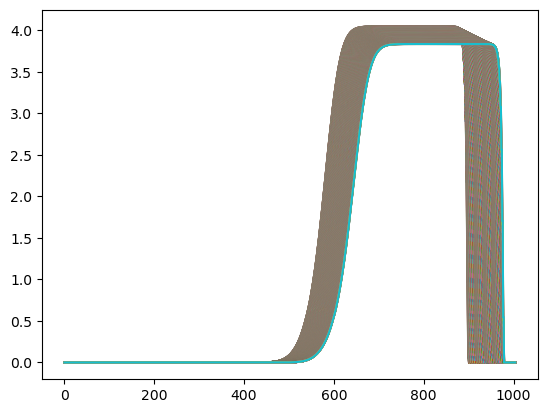

In [158]:
for i in range(1000):
    sim.propagate()
    plt.plot(sim.n)

In [132]:
((sim.n@sim.Ady)@sim.Ady)[7]  

20.0

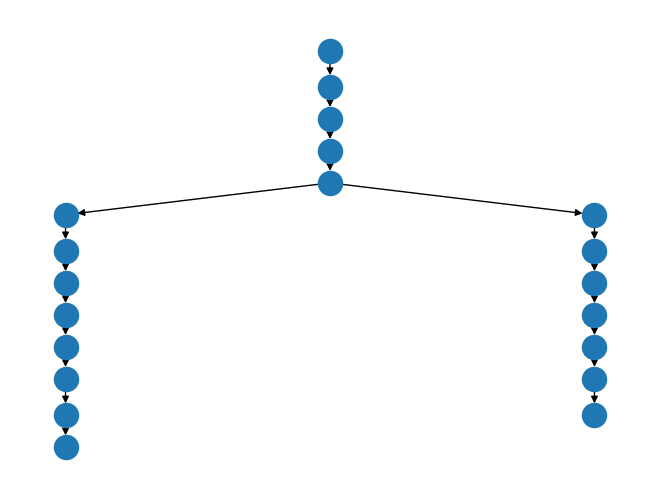

In [129]:
H = nx.DiGraph(tree.adj)
pos = graphviz_layout(H, prog='dot')
nx.draw(H.subgraph(list(range(0, 20, 1))), pos)

In [123]:
tree.adj

array([[False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False,  True,  True,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False,  True,  True,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True, False, False, False, False],
       [False, False, Fa

In [149]:
L_aut_gamma = []
L_aut_gamma_std = []
for k in [2, 10]:
    for gamma in np.arange(0.0, 1.1, 0.1):
        L_aut_gamma.append(L_aut[k][gamma][0][-1])
        L_aut_gamma_std.append(L_aut[k][gamma][1][-1])

In [9]:
L_aut[2].keys()

dict_keys([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0])

In [13]:
L_aut[2][0][0][-1]

26.68

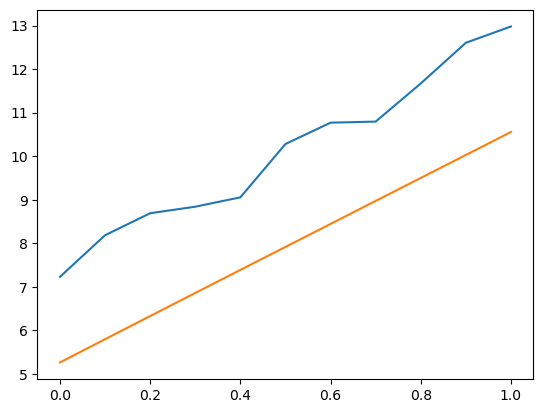

In [115]:
plt.plot(np.arange(0.0, 1.1, 0.1), np.array(L_aut_gamma[0:11])/2)
plt.plot(np.arange(0.0, 1.01, 0.01), L_γ)
#plt.plot(L_aut_gamma[10:])

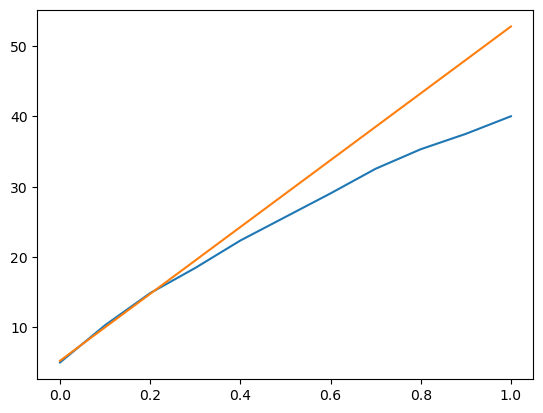

In [154]:
plt.plot(np.arange(0.0, 1.1, 0.1), np.array(L_aut_gamma[11:])/10)
plt.plot(np.arange(0.0, 1.01, 0.01), L_γ)

In [89]:
def δ(no, L, r, rd, γ, k, ro, I, G):
    A = r*I*(1+γ*(k-1))
    return (ro/(A) - no)*L/no*(2*A*no + rd - 2*r)/(A*no + rd - 2*r)

In [109]:
Δ = []
for γ in np.arange(0.0, 1.1, 0.1):
    ode2_net = ODE2_network( G= 100/0.2, ro= 0.4/0.2, rd = 0.4/0.2, I = 0.5, gamma=γ, k = 10, L=None, alpha=1., Q=2)
    Δ.append(δ(ode2_net.n0, ode2_net.L, 0.2, 0.4, 10, γ, 0.4, 0.5))

/tmp/ipykernel_852513/2104798429.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return (ro/(A) - no)*L/no*(2*A*no + rd - 2*r)/(A*no + rd - 2*r)


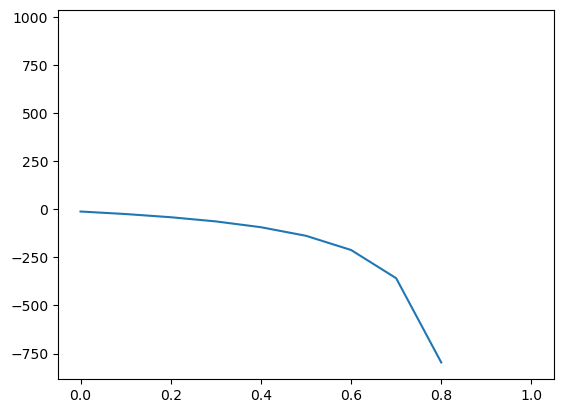

In [111]:
plt.plot(np.arange(0.0, 1.1, 0.1), Δ)

In [99]:
L_aut[10][0.0][0][-1]

71.68

In [106]:
ode2_net = ODE2_network( G= 100/0.2, ro= 0.4/0.2, rd = 0.4/0.2, I = 0.5, gamma=γ, k = 10, L=None, alpha=1., Q=2)

In [107]:
ode2_net.L

52.77906466067828

In [108]:
ode2_net.n0

0.4

In [179]:
L_int = []
for γ in np.arange(0.0, 1.1, 1.):
    el = 5, 200 # size of binary trees
    samples = 100
    gamma = γ
    dt = .1
    key = random.PRNGKey(0)
    k = 2
    # define graph structure
    tree = BiTree(*el, k, gamma)
    # transform Ady into a sparse matrix
    Ady = jsparse.BCOO.from_scipy_sparse(sparse.coo_array(tree.adj))
    start = time.time()
    print(start)
    sim = RKPropagator1D( Ady.shape[0], sub_ix=innn, inn = innn, obs = [0], Ady = tree.adj, n0=100, τo = 0.4, rd = 0.4, r = 0.2, I = 0.5, G_in= G*2, tmax = 100, Δt = .1, λ = 1., method='frequency')
    n_int, L, t, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()
    end = time.time()
    L_int.append(L)
    print(end - start)

1696999909.4947665
5.926143407821655
1696999915.4243972
11.236018657684326


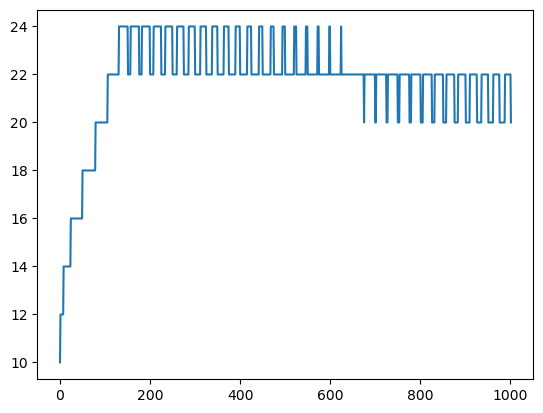

In [168]:
plt.plot(L_int[1])
#plt.axis(xmin=0, xmax=110, ymin=0, ymax=20)

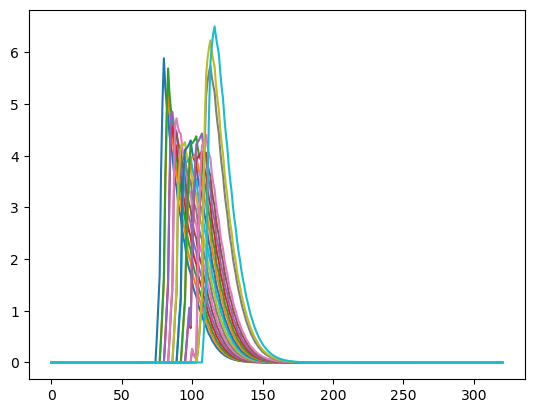

In [142]:
for i in range(20):
    plt.plot(np.array(n_int)[:,60+i])

In [141]:
Inn_in_time[100]

[73, 74]

In [177]:
plt.plot(np.array(n_int)[:,70])

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

In [38]:
n_aut[2][0]

[[(Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array([5, 6], dtype=int32)),
  (Array([100, 100], dtype=int32), Array

In [ ]:
n_in_time_ave = []
for i in range(len(n_aut[2][1.0])):
    n_ = jnp.vstack(([decompress_density(*n_, ix0=0, ix1=el[1]*k+5-1) for n_ in n_aut[2][0][i]]))
    y = n_.mean(0)
    n_in_time_ave.append(y)

In [ ]:
plt.plot(np.array(n_in_time_ave)[3])
plt.show()

In [57]:
sim = RKPropagator1D( Ady.shape[0], sub_ix=[1, 2, 3, 4], inn = [4], obs = [0], Ady = tree.adj, n0=10, τo = 0.3, rd = 0.35, r = 0.3, I = 0.8, G_in= 10, tmax = 50, Δt = 0.1, λ = 1., method='frequency')
n_int, L, t, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()

In [ ]:
        plt.plot(np.arange(0, 1700, 100), L_a[k])
        plt.fill_between(np.arange(0, 1700, 100), np.array(L_t)-np.array(L_std),  np.array(L_t)+np.array(L_std), alpha=.2)
        plt.xlabel('time')
        #plt.axis(ymin=0)
        plt.ylabel('$L(t)$', fontsize='large')
        plt.legend(fontsize = 'x-small')
        plt.title("Q = "+ str(k1))
        

In [90]:
a

1